**Dataset can be downloaded by using following code**

The audio file jazz.00054 is deleted since it is corrupted and causes the code to fail.

In [ ]:
#!pip install kaggle

#!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

#import zipfile

#with zipfile.ZipFile('gtzan-dataset-music-genre-classification.zip', 'r') as zip_ref:
#    zip_ref.extractall('gtzan_dataset')

#print("Download and extraction completed!")

#file_path = 'gtzan_dataset\\Data\\genres_original\\jazz\\jazz.00054.wav'

#if os.path.exists(file_path):
#    os.remove(file_path)
#    print(f"File '{file_path}' has been deleted.")

### Necessary libraries are imported

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
import math
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import librosa
import numpy as np
import os
from scipy.ndimage import zoom
import soundfile as sf

# Set the random seeds
random_seed = 2299436
torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Model Implementation

In [2]:
# This implementation is based on the DenseNet-BC implementation in torchvision
# https://github.com/pytorch/vision/blob/master/torchvision/models/densenet.py

def _bn_function_factory(norm, relu, conv):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = conv(relu(norm(concated_features)))
        return bottleneck_output

    return bn_function


class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size * growth_rate,
                        kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                        kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate
        self.efficient = efficient

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.norm1, self.relu1, self.conv1)
        if self.efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                efficient=efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 3 or 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
            (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        small_inputs (bool) - set to True if images are 32x32. Otherwise assumes images are larger.
        efficient (bool) - set to True to use checkpointing. Much more memory efficient, but slower.
    """
    def __init__(self, growth_rate=12, block_config=(6, 12, 24, 16), compression=0.5,
                 num_init_features=24, bn_size=4, drop_rate=0,
                 num_classes=10, small_inputs=True, efficient=False):

        super(DenseNet, self).__init__()
        assert 0 < compression <= 1, 'compression of densenet should be between 0 and 1'

        # First convolution
        if small_inputs:
            self.features = nn.Sequential(OrderedDict([
                ('conv0', nn.Conv2d(3, num_init_features, kernel_size=3, stride=1, padding=1, bias=False)),
            ]))
        else:
            self.features = nn.Sequential(OrderedDict([
                ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ]))
            self.features.add_module('norm0', nn.BatchNorm2d(num_init_features))
            self.features.add_module('relu0', nn.ReLU(inplace=True))
            self.features.add_module('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1,
                                                           ceil_mode=False))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                efficient=efficient,
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=int(num_features * compression))
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = int(num_features * compression)

        # Final batch norm
        self.features.add_module('norm_final', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Initialization
        for name, param in self.named_parameters():
            if 'conv' in name and 'weight' in name:
                n = param.size(0) * param.size(2) * param.size(3)
                param.data.normal_().mul_(math.sqrt(2. / n))
            elif 'norm' in name and 'weight' in name:
                param.data.fill_(1)
            elif 'norm' in name and 'bias' in name:
                param.data.fill_(0)
            elif 'classifier' in name and 'bias' in name:
                param.data.fill_(0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out


In [3]:
class DenseNetModel(nn.Module):
    def __init__(self, num_classes,small_inputs=False):
        super(DenseNetModel, self).__init__()
        self.dense_net = DenseNet(small_inputs=small_inputs, num_classes=num_classes, drop_rate=0.5, num_init_features=24)

    def forward(self, x):
        return self.dense_net(x)

Device is set to GPU if available

In [4]:
if (torch.cuda.is_available()):
        print(torch.cuda.get_device_name(0))
else:   
    print("no GPU found")        
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   
device = torch.device(dev)

NVIDIA GeForce RTX 4060 Ti


# Custom dataset class is created to facilitate data loading

In [5]:
data_dir = "gtzan_dataset\Data\genres_original"

In [6]:
class AudioDataset(Dataset):
    # Dataset is initialized by giving the root_dir of dataset,
    #label_encoder that will be used for encoding labels,
    #and some transform functions that transforms audio file into
    #required format. There must be exactly three transforms for the model
    #to work properly.
    def __init__(self, root_dir, label_encoder, transforms=None):
        self.root_dir = root_dir
        self.file_list = os.listdir(root_dir)
        self.label_encoder = label_encoder
        self.transforms = transforms

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        file_name = os.path.join(self.root_dir, self.file_list[idx])
            
        waveform, sample_rate = librosa.load(file_name)
        
        label = os.path.splitext(self.file_list[idx])[0]
        label = label.split('.')[0]
        
        encoded_label = self.label_encoder.transform([label])[0]
        
        feature = None
        
        if self.transforms:
            for transform in self.transforms:
                res = transform(waveform)
                res = np.expand_dims(res, axis=0)
                
                if feature is None:
                    feature = res
                else:
                    feature = np.concatenate((feature, res), axis=0)
            
        return feature, encoded_label

# Training-Validation Functions

In [7]:
#these functions are adopted from DI504 2024 Spring Assignment
def train(dataloader, model, loss, optimizer):
    losses = []
    true_positive = 0
    model.train()
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        
        class_scores = model(inputs)
        
        optimizer.zero_grad()
        train_loss = loss(class_scores,labels)
        train_loss.backward()
        optimizer.step()
        
        losses.append(train_loss.item())
        
        predicted_class = torch.argmax(class_scores, dim=1)

        true_positive_batch = torch.sum(predicted_class == labels.to(device))
        true_positive += true_positive_batch.item()

    accuracy = true_positive / len(dataloader.dataset)

    return losses, accuracy

def validate(dataloader, model, criterion):
    losses = []
    preds = []
    actuals = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:

            inputs = inputs.to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
                
            class_scores = model(inputs)

            val_loss = criterion(class_scores, labels)
            losses.append(val_loss.item())

            predicted_class = torch.argmax(class_scores, dim=1)
            
            preds.extend(predicted_class.tolist())
            actuals.extend(labels.tolist())

    return losses, preds, actuals

def accuracy(preds, actuals):
    return sum(np.array(preds) == np.array(actuals))/len(actuals)

In [8]:
def train_and_validate(train_loader, val_loader, model, criterion, optimizer, scheduler, num_epochs = 10):
    "Code is taken and modified from DI504 assignment"
    train_loss_list = []
    val_loss_list = []

    for epoch in range(num_epochs):
        tr_l, tr_acc = train(train_loader, model, criterion, optimizer)
        vl_l, pred, act = validate(val_loader, model, criterion)
        val_acc = accuracy(pred, act)
        
        print(f"End of epoch: {epoch+1}: Train loss: {np.mean(tr_l)}    Valid loss: {np.mean(vl_l)}")
        print(f"Train Acc: {tr_acc*100:.2f}%    Valid Acc: {val_acc*100:.2f}%")
        
        train_loss_list.extend(tr_l)
        val_loss_list.extend(vl_l)
        
        scheduler.step()

    return train_loss_list, val_loss_list

In [9]:
def plot_loss_graph(loss_list):
    """Given a list of loss curves, plot smoothed versions
    The smaller list is "upscaled" by repeating observations 
    to match the size of the bigger list.
    
    (Code is taken from DI504 assignment.)
    """    
    filter_size = 30
    moving_average_filter = [1/filter_size] * filter_size
    plt.figure()
    plt.xlabel('Iterations')
    plt.ylabel('Losses')
    lenghts = [len(x) for x in loss_list]
    relative_len = np.round(max(lenghts)/np.array(lenghts))
    for i,loss in zip(relative_len, loss_list):
        smoothed_loss_list = np.convolve(loss, moving_average_filter, 'valid') 
        plt.plot(np.repeat(smoothed_loss_list,i))
    plt.legend(['Train Loss','Val Loss'])

def print_test_accuracy(model,test_loader, criterion):
    tst_l, pred, act = validate(test_loader,model, criterion)
    test_acc = accuracy(pred, act)
    print(f"Test Acc: {test_acc*100}%")

# Feature Extraction Functions

These functions can be passed to AudioDataset as transforms.
Ex: If user wants a 3D input that consists of the same mel spectrogram in each dimension -> 
transforms = [get_mel,get_mel,get_mel]

In [10]:
def get_mel(audio):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=22050, n_mels=256)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db
 
def get_mfcc(audio):
    mfcc = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=13)
    #resize to fit 256x130 shape
    zoom_factors = (256 / mfcc.shape[0], 1)
    resized_array = zoom(mfcc, zoom_factors, order=1)
    return resized_array

def get_stft(audio):
    stft = np.abs(librosa.stft(audio))
    #resize to fit 256x130 shape
    zoom_factors = (256 / stft.shape[0], 1)
    resized_array = zoom(stft, zoom_factors, order=1)
    return resized_array
    

# Helper Functions

plot_feature method can be used to view the mel spectrograms, mfccs, and stfts

In [25]:
def plot_feature(ftr):
    plt.figure(figsize=(5, 3))
    librosa.display.specshow(ftr, sr=22050, x_axis='time', y_axis=None, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Feature')
    plt.tight_layout()
    plt.show()

# Data Processing Examples

In [26]:
data_folder = "split_genres_original"

file_list = os.listdir(data_folder)
labels = [os.path.splitext(file)[0].split('.')[0] for file in file_list]
label_encoder = LabelEncoder()
label_encoder.fit(labels)

example = AudioDataset(data_folder, label_encoder, transforms = [get_mel,get_mfcc,get_stft])


## Mel spectrogram

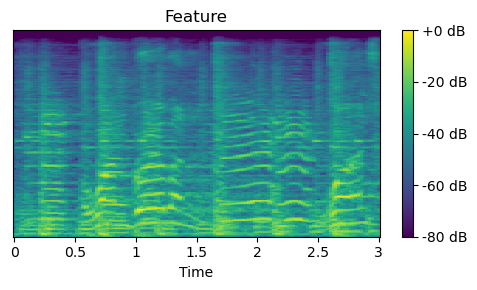

In [27]:
plot_feature(example[0][0][0])

## MFCC

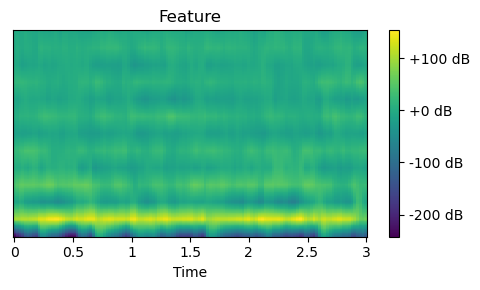

In [28]:
plot_feature(example[0][0][1])

## STFT

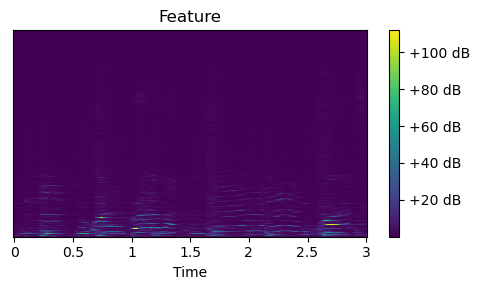

In [29]:
plot_feature(example[0][0][2])

# Dataset creation functions

These function are used to create my own dataset from the downloaded original dataset.

In [12]:
def create_dataset_folder(input_file, output_folder,func, segment_duration=3):
    # ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # iterate through each genre folder
    for genre_folder in os.listdir(data_dir):
        genre_path = os.path.join(data_dir, genre_folder)
        if os.path.isdir(genre_path):
            # iterate through each audio file in the genre folder
            for audio_file in os.listdir(genre_path):
                if audio_file.endswith(".wav"):
                    audio_file_path = os.path.join(genre_path, audio_file)
                    # apply given function on audio file and save them
                    func(audio_file_path, output_folder, segment_duration)

This function is used to split the 30 second long audio files into 3 second long segments and save to given output folder.

In [13]:
def split_audio_file(input_file, output_folder, segment_duration=3):
    y, sr = librosa.load(input_file, sr=22050)
    total_samples = len(y)
    samples_per_segment = sr * segment_duration
    num_segments = int(np.ceil(total_samples / samples_per_segment))
    for i in range(num_segments):     
        start_sample = int(i * samples_per_segment)
        end_sample = min(start_sample + samples_per_segment, total_samples)
        if ((end_sample - start_sample) < samples_per_segment):
            continue
        segment = y[start_sample:end_sample] 
        
        output_file = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(input_file))[0]}_{i}.wav")
        sf.write(output_file, segment, sr)

This function is used to split the 30 second long audio files into 3 second long segments with 50% overlap, add noise to another copy of the segment and save both of the outputs to given output folder.

In [14]:
def augment_audio_file(input_file, output_folder, segment_duration=3):
    y, sr = librosa.load(input_file, sr=22050)
    total_samples = len(y)
    samples_per_segment = sr * segment_duration
    num_segments = int(np.ceil(total_samples / samples_per_segment)) * 2 - 1
    for i in range(num_segments):
        #overlap 50% of the audio files        
        start_sample = int(i * samples_per_segment * 0.5)
        end_sample = min(start_sample + samples_per_segment, total_samples)
        if ((end_sample - start_sample) < samples_per_segment):
            continue
        segment = y[start_sample:end_sample] 
        
        output_file = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(input_file))[0]}_{i}.wav")
        sf.write(output_file, segment, sr)
        
        ##add noise
        output_file = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(input_file))[0]}_{i}_noise.wav")    
        noise = np.random.randn(len(segment))
        segment = segment + noise*0.1
        sf.write(output_file, segment, sr)

This function returns training, validation, and test dataloaders with given proportions and batch size.

In [15]:
def get_train_val_test_loaders(dataset, train_size = 0.7, validation_size = 0.2, test_size = 0.1, batch_size = 32):  
    
    if (abs(train_size + validation_size + test_size - 1) > 0.001):
        raise ValueError("The sum of train_size, validation_size, and test_size must be 1.0")
        
    total_size = len(dataset)
    train_size = int(train_size * total_size)
    val_size = int(validation_size * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

# Baseline Model

For the training of baseline model, original dataset split into 3 second audio segments to increase data size

In [ ]:
#Run this cell to create folder "split_genres_original" that includes 3 second long segments of the original audio files.

#output_folder = "split_genres_original"
#create_dataset_folder(data_dir,output_folder,split_audio_file, segment_duration = 3)

Baseline dataset is created by using the new dataset. To make the data sutiable for DenseNet, mel spectrograms are concatenated 3 times.

In [16]:
data_folder = "split_genres_original"

file_list = os.listdir(data_folder)
labels = [os.path.splitext(file)[0].split('.')[0] for file in file_list]
label_encoder = LabelEncoder()
label_encoder.fit(labels)

baseline_dataset = AudioDataset(data_folder, label_encoder, transforms = [get_mel,get_mel,get_mel])

In [18]:
base_tr_loader, base_val_loader, base_tst_loader = get_train_val_test_loaders(baseline_dataset, train_size = 0.7, 
                                                                              validation_size = 0.2, 
                                                                              test_size = 0.1, batch_size = 32)

Model, loss function, optimizer, and scheduler are initialized with following hyperparameters.

In [19]:
base_model = DenseNetModel(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(base_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [24]:
base_train_loss_list, base_val_loss_list = train_and_validate(base_tr_loader, base_val_loader, base_model, criterion, 
                                                              optimizer, scheduler, num_epochs = 10)

End of epoch: 1: Train loss: 1.5790263653890182    Valid loss: 2.389947949893891
Train Acc: 42.67%    Valid Acc: 31.66%
End of epoch: 2: Train loss: 1.130516476827125    Valid loss: 4.0031859420594715
Train Acc: 60.03%    Valid Acc: 24.55%
End of epoch: 3: Train loss: 0.9548494290543473    Valid loss: 9.683045447818817
Train Acc: 66.96%    Valid Acc: 13.98%
End of epoch: 4: Train loss: 0.7932746290616249    Valid loss: 1.3208904285279532
Train Acc: 72.56%    Valid Acc: 57.06%
End of epoch: 5: Train loss: 0.7331482362529459    Valid loss: 2.8644842779825606
Train Acc: 74.66%    Valid Acc: 32.77%
End of epoch: 6: Train loss: 0.6439032751947777    Valid loss: 3.655459195848495
Train Acc: 77.87%    Valid Acc: 28.36%
End of epoch: 7: Train loss: 0.5797322776219617    Valid loss: 1.621646761894226
Train Acc: 80.19%    Valid Acc: 52.05%
End of epoch: 8: Train loss: 0.5302731491387163    Valid loss: 1.729859957619319
Train Acc: 81.55%    Valid Acc: 50.90%
End of epoch: 9: Train loss: 0.4932762

Test Acc: 55.85585585585585%


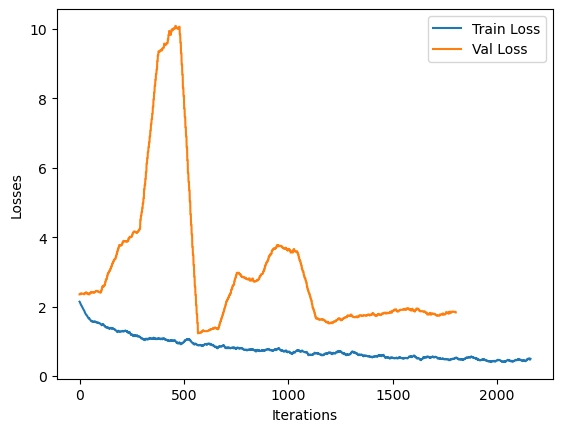

In [25]:
plot_loss_graph([base_train_loss_list,base_val_loss_list])
print_test_accuracy(base_model,base_tst_loader,criterion)
#plt.savefig("baseline", dpi=300)

# Data Augmentation

In [26]:
#Run this block to create augmented dataset

#output_folder = "augmented_genres_original"
#create_dataset_folder(data_dir,output_folder,augment_audio_file, segment_duration = 3)

## Initial Training

In [27]:
data_folder = "augmented_genres_original"

file_list = os.listdir(data_folder)
labels = [os.path.splitext(file)[0].split('.')[0] for file in file_list]
label_encoder = LabelEncoder()
label_encoder.fit(labels)

augmented_dataset = AudioDataset(data_folder, label_encoder, transforms = [get_mel,get_stft,get_mfcc])

In [28]:
aug_tr_loader, aug_val_loader, aug_tst_loader = get_train_val_test_loaders(augmented_dataset, train_size = 0.7, 
                                                                              validation_size = 0.2, 
                                                                              test_size = 0.1, batch_size = 32)

In [29]:
aug_model = DenseNetModel(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(aug_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [31]:
aug_train_loss_list, aug_val_loss_list = train_and_validate(aug_tr_loader, aug_val_loader, aug_model, criterion, 
                                                              optimizer, scheduler, num_epochs = 10)

End of epoch: 1: Train loss: 1.4398312651249299    Valid loss: 1.699889052064479
Train Acc: 48.23%    Valid Acc: 46.80%
End of epoch: 2: Train loss: 1.0409968764667052    Valid loss: 1.227396619920971
Train Acc: 63.92%    Valid Acc: 60.67%
End of epoch: 3: Train loss: 0.8540828274316098    Valid loss: 1.6582792902193149
Train Acc: 70.44%    Valid Acc: 53.02%
End of epoch: 4: Train loss: 0.734274230233158    Valid loss: 1.3077529041456575
Train Acc: 74.60%    Valid Acc: 62.05%
End of epoch: 5: Train loss: 0.6461354416896061    Valid loss: 0.7921408501868489
Train Acc: 77.84%    Valid Acc: 75.80%
End of epoch: 6: Train loss: 0.5543242083256503    Valid loss: 0.7378029204091104
Train Acc: 81.07%    Valid Acc: 77.46%
End of epoch: 7: Train loss: 0.48679187353475983    Valid loss: 1.433863493261718
Train Acc: 83.25%    Valid Acc: 65.70%
End of epoch: 8: Train loss: 0.44661034581711495    Valid loss: 1.1206304794099151
Train Acc: 84.56%    Valid Acc: 70.33%
End of epoch: 9: Train loss: 0.392

Test Acc: 71.83877766069547%


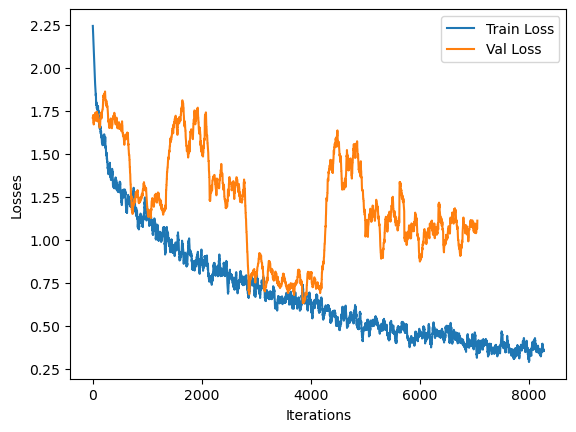

In [33]:
plot_loss_graph([aug_train_loss_list, aug_val_loss_list])
print_test_accuracy(aug_model,aug_tst_loader,criterion)
#plt.savefig("aug_model", dpi=300)

# Hyperparameter Tuning

Different hyperparameters for batch size and L2 penalty are tried and 32 batch size and 10e-5 L2 penalty are found as the best hyperparameters. The tuning process was done before changing the codebase in a way that will not affect these results. Therefore tuning process are not shown here due to limited time.

# Feature Stacking

In [34]:
data_folder = "augmented_genres_original"

file_list = os.listdir(data_folder)
labels = [os.path.splitext(file)[0].split('.')[0] for file in file_list]
label_encoder = LabelEncoder()
label_encoder.fit(labels)

feature_stacked_dataset = AudioDataset(data_folder, label_encoder, transforms = [get_mel,get_mfcc,get_stft])

In [35]:
stck_tr_loader, stck_val_loader, stck_tst_loader = get_train_val_test_loaders(feature_stacked_dataset, train_size = 0.7, 
                                                                              validation_size = 0.2, 
                                                                              test_size = 0.1, batch_size = 32)

In [36]:
stck_model = DenseNetModel(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(stck_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [37]:
stck_train_loss_list, stck_val_loss_list = train_and_validate(stck_tr_loader, stck_val_loader, stck_model, criterion, 
                                                              optimizer, scheduler, num_epochs = 10)

End of epoch: 1: Train loss: 1.4640938547002265    Valid loss: 2.4964310321487297
Train Acc: 47.23%    Valid Acc: 37.86%
End of epoch: 2: Train loss: 1.0624484076916454    Valid loss: 1.3081301155210543
Train Acc: 63.03%    Valid Acc: 58.16%
End of epoch: 3: Train loss: 0.8971182172556957    Valid loss: 1.715393620378831
Train Acc: 69.07%    Valid Acc: 50.12%
End of epoch: 4: Train loss: 0.7692334657332983    Valid loss: 1.0018184913807557
Train Acc: 73.41%    Valid Acc: 69.11%
End of epoch: 5: Train loss: 0.6670528415635407    Valid loss: 0.8941818664805228
Train Acc: 77.18%    Valid Acc: 72.76%
End of epoch: 6: Train loss: 0.5587753921029079    Valid loss: 0.8167279326364774
Train Acc: 81.11%    Valid Acc: 73.44%
End of epoch: 7: Train loss: 0.4949599638311978    Valid loss: 0.8019380088613814
Train Acc: 82.94%    Valid Acc: 76.01%
End of epoch: 8: Train loss: 0.4392517585801073    Valid loss: 0.704264681629774
Train Acc: 85.13%    Valid Acc: 77.03%
End of epoch: 9: Train loss: 0.400

Test Acc: 83.61433087460485%


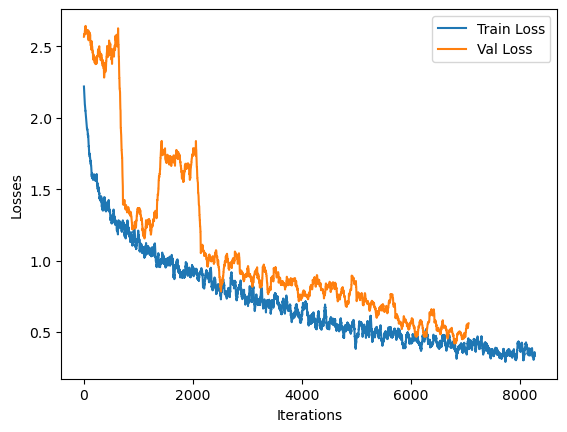

In [38]:
plot_loss_graph([stck_train_loss_list, stck_val_loss_list])
print_test_accuracy(stck_model,stck_tst_loader,criterion)
#plt.savefig("stacked_model", dpi=300)